In [ ]:

import torch
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import re
import openai
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [116]:
# Load trained model
model_path = "roberta_fakenews_model"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Cleaning Functions

In [117]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

@torch.no_grad()
def classify_with_roberta(text):
    cleaned = clean_text(text)
    inputs = tokenizer(cleaned, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1).squeeze().tolist()
    label = torch.argmax(logits, dim=1).item()  # → 0 or 1
    y_score = probs[1]
    return label, y_score

def classify_claim(claim_text, model="gpt-4-turbo"):
    """Calls OpenAI API to classify a claim as SUPPORTS or REFUTES."""
    if not isinstance(claim_text, str) or claim_text.strip() == "":
        return None

    prompt = f"""
    Determine whether the following claim is "SUPPORTS" or "REFUTES".
    Provide only 0 if "SUPPORTS" or 1 if "REFUTES" as the output.

    Claim:
    {claim_text}
    """

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a fact-checking AI."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        prediction = response.choices[0].message.content.strip()
        return prediction if prediction in ["1", "0"] else None

    except Exception as e:
        print(f"LLM Error: {e}")
        return None


def classify_with_llm(text):
    result = classify_claim(text)
    if result == "0":
        return 0  # SUPPORTS → Real
    elif result == "1":
        return 1  # REFUTES → Fake
    else:
        return "Unable to determine"  # Uncertain

## Domain-Aware Routing (Hard Split)

In [118]:
def detect_domain_by_length(text, threshold=30):
    return "reuters" if len(text.split()) > threshold else "fever"

def ensemble_router(text):
    domain = detect_domain_by_length(text)

    if domain == "reuters":
        label, score = classify_with_roberta(text)
    elif domain == "fever":
        label = classify_with_llm(text)
        score = float(label)
    else:
        raise ValueError("Invalid input")

    return label,score, domain  # 0 = Real, 1 = Fake

In [119]:
# Load data
true_df = pd.read_csv("../data/True.csv")
false_df = pd.read_csv("../data/Fake.csv")
fever_df = pd.read_excel("../data/filtered_fever_data.xlsx")

# Add labels
true_df["label"] = 0
false_df["label"] = 1

# Standardize fever labels
fever_df["label"] = fever_df["label"].map({"SUPPORTS": 0, "REFUTES": 1})

# Clean and unify columns
true_df["text"] = true_df["title"] + " " + true_df["text"]
false_df["text"] = false_df["title"] + " " + false_df["text"]

# Select and unify necessary columns
true_df = true_df[["text", "label"]]
false_df = false_df[["text", "label"]]
fever_df = fever_df[["claim", "label"]].rename(columns={"claim": "text"})

# Combine all datasets
merged_df = pd.concat([true_df, false_df, fever_df], ignore_index=True)
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [120]:
# Limit to first 300 rows
merged_df = merged_df.iloc[:10]

# Run through ensemble
predictions = []
scores = []
domains = []

for text in merged_df["text"]:
    pred, score, domain = ensemble_router(text)
    predictions.append(pred)
    scores.append(score)
    domains.append(domain)

In [121]:
merged_df["predicted"] = predictions
merged_df["domain"] = domains

excel_path = "ensemble_predictions.xlsx"
merged_df.to_excel(excel_path, index=False)
print(f"Saved predictions to {excel_path}")

Saved predictions to ensemble_predictions.xlsx


In [122]:
merged_df

,text,label,predicted,domain
0,Kingdom of Hearts III won't be playable on two...,1,1,fever
1,Slovakia is peaceful.,0,0,fever
2,House Republican offers bill to keep governmen...,0,0,reuters
3,All the president's women: Duterte's fiercest ...,0,0,reuters
4,Tony Bill directed a film based on a book.,0,1,fever
5,Cristiano Ronaldo reached 100 scores in Europe...,0,1,fever
6,Dhool featured Reemma Sen in a minor role.,1,1,fever
7,Bradford is in West Yorkshire.,0,0,fever
8,OUCH! NEW EMAILS Show Hillary Didn’t Want To F...,1,1,reuters
9,Hillary Clinton had Senator Tim Kaine as her v...,0,0,fever


In [123]:
# Split by domain
fever_df = merged_df[merged_df["domain"] == "fever"]
reuters_df = merged_df[merged_df["domain"] == "reuters"]

# Confusion for FEVER
fever_cm = confusion_matrix(fever_df["label"], fever_df["predicted"])
fever_cm_df = pd.DataFrame(fever_cm, index=["Actual Fake", "Actual Real"], columns=["Pred Fake", "Pred Real"])
print("\nFEVER Confusion Matrix:")
print(fever_cm_df)

# Confusion for REUTERS
reuters_cm = confusion_matrix(reuters_df["label"], reuters_df["predicted"])
reuters_cm_df = pd.DataFrame(reuters_cm, index=["Actual Fake", "Actual Real"], columns=["Pred Fake", "Pred Real"])
print("\nREUTERS Confusion Matrix:")
print(reuters_cm_df)



FEVER Confusion Matrix:
             Pred Fake  Pred Real
Actual Fake          3          2
Actual Real          0          2

REUTERS Confusion Matrix:
             Pred Fake  Pred Real
Actual Fake          2          0
Actual Real          0          1


In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

y_true = merged_df["label"]
y_pred = merged_df["predicted"]  # Already numeric (0/1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual Fake", "Actual Real"], columns=["Pred Fake", "Pred Real"])
print("\nConfusion Matrix (5dp):")
print(cm_df.applymap(lambda x: f"{x:.5f}"))



Confusion Matrix (5dp):
            Pred Fake Pred Real
Actual Fake   5.00000   2.00000
Actual Real   0.00000   3.00000


/var/folders/p4/v_6p0t5d09qd52xqbf4lp_fh0000gn/T/ipykernel_45852/2053473442.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(cm_df.applymap(lambda x: f"{x:.5f}"))


In [129]:
y_scores

0                                     [1.0, 0.0]
1                                     [0.5, 0.5]
2    [0.9999908208847046, 9.160897207038943e-06]
3    [0.9999908208847046, 9.143030183622614e-06]
4                                     [0.0, 1.0]
5                                     [0.0, 1.0]
6                                     [1.0, 0.0]
7                                     [0.0, 1.0]
8    [6.059241513867164e-06, 0.9999939203262329]
9                                     [0.0, 1.0]
Name: probs_real, dtype: object

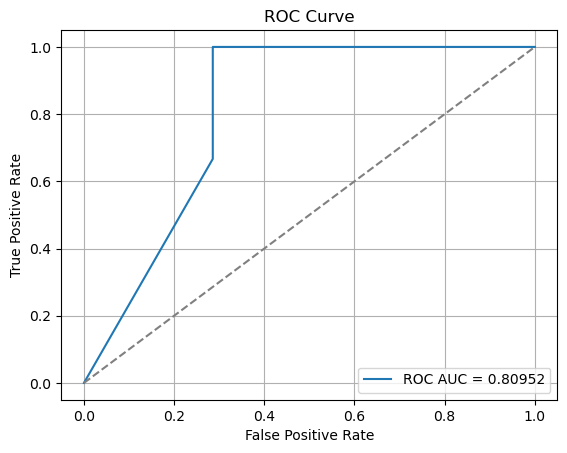

In [133]:
y_true = merged_df["label"].tolist()
y_scores = [s[0] if isinstance(s, list) else s for s in scores]  # handles both [p_fake, p_real] and float

# Compute ROC AUC
roc_auc = roc_auc_score(y_true, y_scores)
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.5f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
